In [1]:
#Mouting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip uninstall keras
!pip install q keras==2.3.1

Uninstalling Keras-2.4.3:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/Keras-2.4.3.dist-info/*
    /usr/local/lib/python3.6/dist-packages/docs/*
    /usr/local/lib/python3.6/dist-packages/keras/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.6/dist-packages/docs/md_autogen.py
    /usr/local/lib/python3.6/dist-packages/docs/update_docs.py
Proceed (y/n)? y
  Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 378kB 6.1MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 


In [3]:
!pip uninstall tensorflow
!pip install q tensorflow==2.2

Uninstalling tensorflow-2.3.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.3.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
y
  Successfully uninstalled tensorflow-2.3.0
     |████████████████████████████████| 516.2MB 33kB/s 
     |████████████████████████████████| 460kB 65kB/s 
     |████████████████████████████████| 3.0MB 46.7MB/s 
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0


In [2]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
# small library for seeing the progress of loops.
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()
#Loading a Text File Into Memory.




Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [4]:
#Loading a Text File Into Memory.

def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text



# Store all 5 captions of each image

def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
        else:
            descriptions[img[:-2]].append(caption)

    return descriptions


#Preprocessing data,We will remove punctuation,",","-" and other non alphanumeric characters.

def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            desc = img_caption.split()
            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string
            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions


    #Building vocabularry of all unique words

def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab


#All descriptions in one file 
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()
 
 #Preparing all the paths of datasets required.

#Contains all text files containing image name and captions related with them.
dataset_text = "/content/drive/My Drive/Dataset/Flickr_8k_text"

#Contains 8000 images.
dataset_images = "/content/drive/My Drive/Dataset/Flicker8k_Dataset"

#we prepare our text data
#Preparing all the paths of datasets required.

#Contains all text files containing image name and captions related with them.
dataset_text = "/content/drive/My Drive/Dataset/Flickr_8k_text"

#Contains 8000 images.
dataset_images = "/content/drive/My Drive/Dataset/Flicker8k_Dataset"

#we prepare our text data
filename = dataset_text + "/" + "Flickr8k.token.txt"

descriptions = all_img_captions(filename)

print("Length of descriptions =" ,len(descriptions))
num=0
for key in descriptions.keys():
  for item in descriptions[key]:
    num=num+1

print("Number of captions =",num)

cnt=0

for key in descriptions.keys():
  if(cnt>5):
    break
  print(key,end=" ")
  print(descriptions[key])
  cnt=cnt+1


#cleaning the descriptions
clean_descriptions = cleaning_text(descriptions)

cnt=0
print("\n\nClean descriptions\n")
for key in clean_descriptions.keys():
  if(cnt>5):
    break
  print(key,end=" ")
  print(clean_descriptions[key])
  cnt=cnt+1


#building vocabulary 
vocabulary = text_vocabulary(clean_descriptions)

#Vocabulary Stores all unique words occuring in all captions

print("\nLength of vocabulary = ", len(vocabulary))

#saving each description to file 
save_descriptions(clean_descriptions, "descriptions.txt")


def extract_features(directory):
        model = Xception( include_top=False, pooling='avg' )
        features = {}
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            #image = preprocess_input(image)
            image = image/127.5
            image = image - 1.0
            feature = model.predict(image)
            features[img] = feature
        return features
#2048 feature vector
features = extract_features(dataset_images)
dump(features, open("/content/drive/My Drive/Dataset/features.p","wb"))


#load the data 
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos


def load_clean_descriptions(filename, photos): 
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words)<1 :
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + '<end>'
            descriptions[image].append(desc)
    return descriptions



def load_features(photos):
    #loading all features
    all_features = load(open("/content/drive/My Drive/Dataset/features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features

####TRAINING DATASET

filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"

#Training dataset named Flickr_8k.trainImages.txt contains name of 6000 images which are being used for training our model. 
train_imgs = load_photos(filename)

train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)

train_features = load_features(train_imgs)


#converting dictionary to clean list of descriptions

def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc


#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary

from keras.preprocessing.text import Tokenizer

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer


# give each word an index, and store that into tokenizer.p pickle file

tokenizer = create_tokenizer(train_descriptions)

dump(tokenizer, open('tokenizer.p', 'wb'))

vocab_size = len(tokenizer.word_index) + 1

#calculate maximum length of descriptions

def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)

max_length = max_length(descriptions)

print("\nMax length of a caption in given dataset= ",max_length)

#Data generator funnction is used by Model.fit_generator function.

def data_generator(descriptions, features, tokenizer, max_length):
    while True:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[input_image, input_sequence], output_word] 
            #yield is a keyword in Python that is used to return from a function without destroying the states of its local variable 


#This function makes the sequence of a caption by taking previous sequence and feature vector and predicts the output word.

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)


[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))

print("\n")

print(a.shape, b.shape, c.shape)






Length of descriptions = 8092
Number of captions = 40460
1000268201_693b08cb0e.jpg ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']
1001773457_577c3a7d70.jpg ['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .']
1002674143_1b742ab4b8.jpg ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .', 'A little girl is sitting in front of a large painted rainbow .', 'A small girl in the grass plays with fingerpaints in front of a white canvas with a

In [ ]:
# MODEL CONSISTING OF LSTM AND CNN

from keras.utils import plot_model

# define the captioning model

def define_model(vocab_size, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)#TO prevent overfitting of neural network.
    fe2 = Dense(256, activation='relu')(fe1)


    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)


    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)


    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')


    # VISUALIZATION of model
    
    print(model.summary())

    plot_model(model, to_file='model.png', show_shapes=True)
    
    return model
    #return model object
  

#TRAINING OUR MODEL.

print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
epochs = 5
steps = len(train_descriptions)

# making a directory models to save our models

os.mkdir("models")

for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save("models/model_" + str(i) + ".h5")

#Training the model






Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 32, 256)      1939712     input_6[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 2048)         0           input_5[0][0]      

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
6000/6000 [==============================] - 484s 81ms/step - loss: 4.5229
Epoch 1/1
6000/6000 [==============================] - 465s 77ms/step - loss: 3.6843
Epoch 1/1
6000/6000 [==============================] - 460s 77ms/step - loss: 3.4010
Epoch 1/1
6000/6000 [==============================] - 463s 77ms/step - loss: 3.2256
Epoch 1/1
6000/6000 [==============================] - 470s 78ms/step - loss: 3.1055


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



Average individual 4-gram Bleu score =  0.30406999999999973

Average BLEU score =  0.5239499999999995


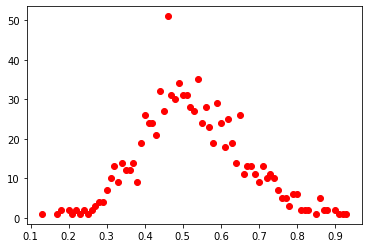

In [26]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse



#Function to return feature vector of an image.

def extract_features(filename, model):
        try:
            image = Image.open(filename)

        except:
            print("ERROR: Couldn't open image!Make sure everything is right.")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature


#Function to return the word at given index.

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

#Function for Predicting sequence of words for caption.

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text


#TESTING ON 1000 IMAGES 

#EVALUATION METRIC IS BLEU SCORE.


file_test = dataset_text + "/" + "Flickr_8k.testImages.txt"

test_imgs = load_photos(file_test)

temp_path="/content/drive/My Drive/Dataset/Flicker8k_Dataset/"
img_path = "/content/drive/My Drive/Dataset/Flicker8k_Dataset/1056249424_ef2a2e041c.jpg"

max_length = 32 #Maximum number of words in a caption.

tokenizer = load(open("tokenizer.p","rb"))

model = load_model('models/model_4.h5')

xception_model = Xception(include_top=False, pooling="avg")

test_descriptions = load_clean_descriptions("descriptions.txt", test_imgs)

from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
sum1=0
sum2=0
avg_bleu_score=0
list1=[]
coun={}
for i in range(1000):
  u=test_imgs[i]
  filename=temp_path+u
  try:
    image = Image.open(filename)
  except:
    print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
  
  img_path=temp_path+u
  
  photo = extract_features(img_path, xception_model)
  
  description = generate_desc(model, tokenizer, photo, max_length)
  
  orig_description=test_descriptions[u]

  # img = Image.open(img_path)

  referernces=orig_description

  candidates=description

  score=sentence_bleu(referernces, candidates)
  score2=sentence_bleu(referernces, candidates,weights=(0,0,0,1))
  score=round(score,2)
  sum1 += score
  score2=round(score2,2)
  sum2 +=score2
  avg_bleu_score += 1
  
  if score not in list1:
    list1.append(score)
    coun[score] = 1
  else:
    coun[score] += 1

list2=[]

list1.sort()

for u in list1:
  list2.append(coun[u])

print("\nAverage individual 4-gram Bleu score = ",sum2/avg_bleu_score)
avg_bleu_score=sum1/avg_bleu_score

print("\nAverage BLEU score = ",avg_bleu_score)


plt.plot(list1,list2,'ro')

description = generate_desc(model, tokenizer, photo, max_length)

start two men play basketball end


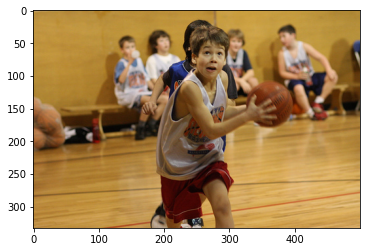

In [18]:
img_path = "/content/drive/My Drive/Dataset/Flicker8k_Dataset/2271755053_e1b1ec8442.jpg"

img=Image.open(img_path)
photo = extract_features(img_path, xception_model)
  
description = generate_desc(model, tokenizer, photo, max_length)

plt.imshow(img)

print(description)